## Startup in my environment
```
cd /local/res/epikmodels/Notebook
conda activate py37
jupyter lab ekat_prob.ipynb
```

## Introduction
This notebook brainstorms adding probabilities via circumstantial probabilities
in a one-coin model.

In [1]:
# hfst_dev is better for graphics
import hfst_dev as hfst
import graphviz
import math

In [2]:
# Weights are negative log probabilities
print(-math.log(0.25))
print(-math.log(0.75))

1.3862943611198906
0.2876820724517809


## States
For machines with fewer states, use atoms for states.

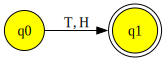

In [3]:
# Bool = hfst.regex('["0"|"1"]')
H = hfst.regex('H')
T = hfst.regex('T')
 

defs = {"H":H,"T":T}

St = hfst.regex('H | T',definitions=defs)
defs.update({"St":St})
St.view()

Machines for the states of the first and second coin.

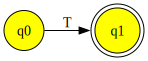

In [4]:
# The coin is tails
T.view()

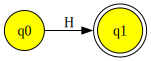

In [5]:
# The coin is heads
H.view()

## Operations

In [6]:
# State complement
# X is a compiled machine that is assumed to be a set of states.
def Nst(X):
    nst = St.copy()
    nst.minus(X)
    return(nst)

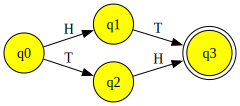

In [7]:
# Sequence of two unequal states.  
UnequalStPair = hfst.regex("[H T] | [T H]",definitions=defs)
UnequalStPair.minimize()
UnequalStPair.view()

### Decorated events
A decorated event is a bare event flanked by compatible states.  

In [8]:
# Peeking is going to be construed as fallible
# Accurate peeks
peekamyHH = hfst.regex('[H peekamyHH H]',definitions=defs)
peekamyTT = hfst.regex('[T peekamyTT T]',definitions=defs)
# Inaccurate peeks
peekamyHT = hfst.regex('[H peekamyHT H]',definitions=defs)
peekamyTH = hfst.regex('[T peekamyTH T]',definitions=defs)

peekbobHH = hfst.regex('[H peekbobHH H]',definitions=defs)
peekbobTT = hfst.regex('[T peekbobTT T]',definitions=defs)
peekbobHT = hfst.regex('[H peekbobHT H]',definitions=defs)
peekbobTH = hfst.regex('[T peekbobTH T]',definitions=defs)


peekamyHH.determinize()
peekamyTT.determinize()
peekamyHT.determinize()
peekamyTH.determinize()

peekbobHH.determinize()
peekbobTT.determinize()
peekbobHT.determinize()
peekbobTH.determinize()


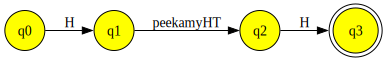

In [9]:
peekamyHT.view()

## Flips

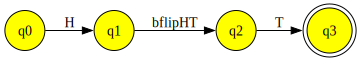

In [10]:
# Flips are going to bieased

# Coin stays the same. These will get a higher probability.
bflipHH =  hfst.regex('[H bflipHH H ]',definitions=defs)
bflipTT =  hfst.regex('[T bflipTT T ]',definitions=defs)

# Coin changes.
bflipHT =  hfst.regex('[H bflipHT T ]',definitions=defs)
bflipTH =  hfst.regex('[T bflipTH H ]',definitions=defs)


bflipHT.view()

In [11]:
# These name decorated events
eventdefs = { 
    "peekamyHH":peekamyHH,
    "peekamyTT":peekamyTT,
    "peekamyHT":peekamyHT,
    "peekamyTH":peekamyTH,
    "peekbobHH":peekbobHH,
    "peekbobTT":peekbobTT,
    "peekbobHT":peekbobHT,
    "peekbobTH":peekbobTH,
    "bflipHH":bflipHH,
    "bflipTT":bflipTT, 
    "bflipHT":bflipHT,
    "bflipTH":bflipTH }

In [12]:
defs.update(eventdefs)

In [13]:
# Amy peeking events 
EventPeekAmy = hfst.regex('[peekamyHH | peekamyTT | peekamyHT | peekamyTH ]', definitions=defs)
EventPeekAmy.determinize()

In [14]:
# Bob peeking events 
EventPeekBob = hfst.regex('[peekbobHH | peekbobTT | peekbobHT | peekbobTH ]', definitions=defs)
EventPeekBob.determinize()

In [15]:
# Flip events
EventFlip = hfst.regex('[bflipHH | bflipTT | bflipHT | bflipTH ]', definitions=defs)
EventFlip.determinize()

In [60]:
defs.update({"EventPeekAmy":EventPeekAmy,"EventPeekBob":EventPeekBob,"EventFlip":EventFlip})

In [16]:
# Redefine Event from three parts
Event = EventPeekAmy.copy()
Event.disjunct(EventPeekBob)
Event.disjunct(EventFlip)
Event.minimize()

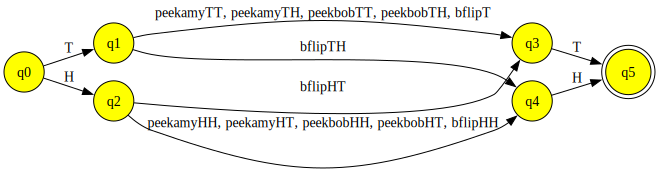

In [17]:
Event.view()

## Bare events and short worlds
A short form a world is obtained by deleting medial states. This is used for display, it is not used in the analysis.

In [18]:
defs.update({"Event":Event,"UnequalStPair":UnequalStPair,"St":St})

In [19]:
DeleteEndState = hfst.regex('St -> 0 || .#. _, _ .#.', definitions=defs)
defs.update({"DeleteEndState":DeleteEndState})

In [20]:
BareEvent = hfst.regex('[Event .o. DeleteEndState].l', definitions=defs)
defs.update({"BareEvent":BareEvent})
list(BareEvent.extract_paths().keys())

['bflipHH',
 'bflipHT',
 'bflipT',
 'bflipTH',
 'peekamyHH',
 'peekamyHT',
 'peekamyTH',
 'peekamyTT',
 'peekbobHH',
 'peekbobHT',
 'peekbobTH',
 'peekbobTT']

In [21]:
# Rewrite relation that deletes medial states
# This is used for visualizing and printing, not in the analysis.
Short0 = hfst.regex('St -> 0 || BareEvent _ BareEvent', definitions=defs)
def short(x):
    y = x.copy()
    y.compose(Short0)
    y.output_project()
    return y
    

## Ekat

In [22]:
# Delete the second state in a block of two states.  This is used defining Ekat concatenation.
Squash = hfst.regex('St -> 0 || St _', definitions = defs)
# Strings that do not contain an unequal state pair
Wf0 = hfst.regex('~[$ UnequalStPair]', definitions = defs)
defs.update({"Squash":Squash,"Wf0":Wf0})

### Ekat product
Concatenate in the string algebra, remove elements that have an unequal state pair, than squash to get into
the Ekat subset.

In [23]:
# define Cn(X,Y) [[[X Y] & Wf0] .o. Squash].l;
def Cn(X,Y):
    Z = X.copy()
    Z.concatenate(Y)
    Z.intersect(Wf0)
    Z.compose(Squash)
    Z.output_project()
    #Z.determinize()
    Z.minimize()
    return Z

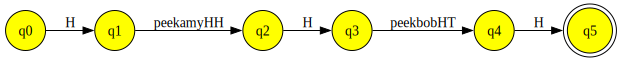

In [24]:
# The two peeks disambiguate to a single state HT
Cn(peekamyHH,peekbobHT).view()

In [25]:
show(Cn(H,peekamyH))
show(Cn(T,peekamyH))

NameError: name 'show' is not defined

### Ekat Kleene operations

In [26]:
# define Kpl(X) [[[X+] & Wf0] .o. Squash].l;
def Kpl(X):
    Z = X.copy()
    Z.repeat_plus()
    Z.intersect(Wf0)
    Z.compose(Squash)
    Z.output_project()
    Z.determinize()
    Z.minimize()
    return Z

In [27]:
# Kleene Star
# The identity is St, not the empty string.
# define Kst(X) St |  Kpl(X);
def Kst(X):
    Z = Kpl(X)
    Z.disjunct(St)
    Z.determinize()
    Z.minimize()
    return(Z)
  

In [28]:
# Inverse of Squash
Squashi = Squash.copy()
Squashi.invert()

In [29]:
# Concatenation of relations
# define Cnr(R,S) Squash.i .o. Wf0 .o. [R S] .o. Wf0 .o. Squash;
def Cnr(R,S):
    Z = R.copy()
    Z.concatenate(S)
    Z.compose(Wf0)
    Z.compose(Squash)
    Z.invert()
    Z.compose(Wf0)
    Z.compose(Squash)
    Z.invert()
    Z.determinize()
    return(Z)
    

In [30]:
# Kleene plus on relations
# define RelKpl(X) Squash.i .o. Wf0 .o. [X+] .o. Wf0 .o. Squash;
def RelKpl(R):
    Z = R.copy()
    Z.repeat_plus() 
    Z.compose(Wf0)
    Z.compose(Squash)
    Z.invert()
    Z.compose(Wf0)
    Z.compose(Squash)
    Z.invert()
    Z.determinize()
    return(Z)

In [31]:
# Kleene star on relations
# This is used in defining world alternative relations.
# The total relation on St is included.
# define RelKst(X) [St .x. St] | RelKpl(X);
def RelKst(R):
    Z = RelKpl(R)
    StxSt = St.copy()
    StxSt.cross_product(St)
    Z.disjunct(StxSt)
    return(Z)

## Examples of product of events

In [32]:
EventName = [ 
 'peekamyHH',
 'peekamyTT',
 'peekamyHT',
 'peekamyTH',
 'peekbobHH',
 'peekbobTT',
 'peekbobHT',
 'peekbobTH', 
 'bflipHH', 
 'bflipHT',
 'bflipTT',
 'bflipTH']

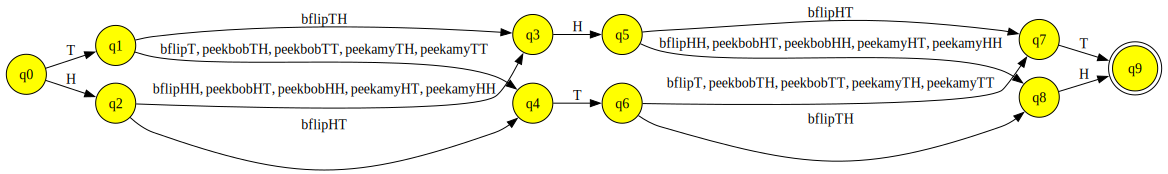

In [34]:
two = Cn(Event,Event)
two.view()

## Worlds

In [35]:
# A world is a concatenation of events
W = Kst(Event)
defs.update({"W":W})

## Alternative relations

In [40]:
# Unconstrained cross product of the decorated events
eventCrossEvent = Event.copy()
eventCrossEvent.cross_product(Event)

defs.update({"eventCrossEvent":eventCrossEvent})
# Shorter name
defs.update({"eCe":eventCrossEvent})  
# eventCrossEvent.view()

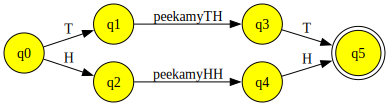

In [53]:
amySeeH = hfst.regex('peekamyHH | peekamyTH', definitions=defs)
amySeeT = hfst.regex('peekamyHT | peekamyTT', definitions=defs)
defs.update({"amySeeH":amySeeH,"amySeeT":amySeeT})
amySeeH.view()

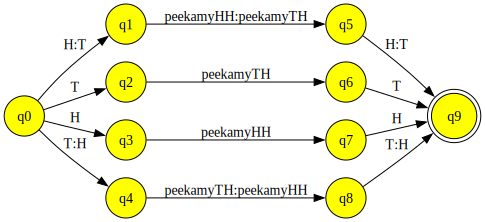

In [57]:
# When Amy sees H in either way, for her she could be seeing H in either way
# Similarly for T.
amySeeHRel =  hfst.regex('[amySeeH .o. eCe .o. amySeeH]', definitions=defs)
amySeeTRel =  hfst.regex('[amySeeT .o. eCe .o. amySeeT]', definitions=defs)
amySeeHRel.view()

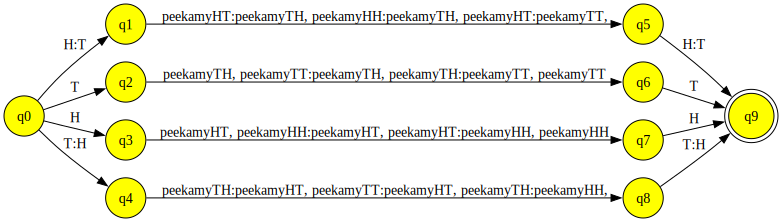

In [61]:
# When Amy peeks, Bob knows only that the is peeking. She could be peeking at anything
# and taking it to be anything.
bobAmyPeekRel =  hfst.regex('[ EventPeekAmy  .o. eCe .o. EventPeekAmy ]', definitions=defs)
bobAmyPeekRel.view()

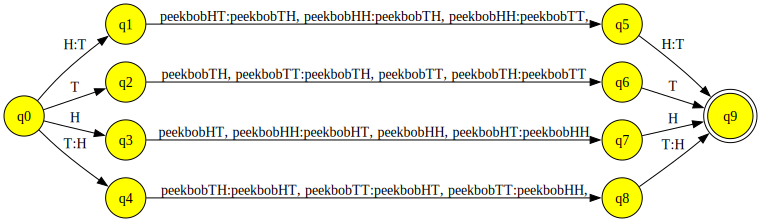

In [62]:
# Symmetrically for Amy
amyBobPeekRel =  hfst.regex('[ EventPeekBob  .o. eCe .o. EventPeekBob ]', definitions=defs)
amyBobPeekRel.view()

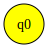

In [65]:
# Finally Bob's relation for Bob seeing
bobSeeH = hfst.regex('peekbobHH | peekbobTH', definitions=defs)
bobSeeT = hfst.regex('peekbobHT | peekbobTT', definitions=defs)

bobSeeHRel =  hfst.regex('[bobSeeH .o. eCe .o. bobSeeH]', definitions=defs)
bobSeeTRel =  hfst.regex('[bobSeeT .o. eCe .o. bobSeeT]', definitions=defs)
bobSeeHRel.view()

In [68]:
print(-math.log(0.75))
threequarter = hfst.regex('[St:St]::0.2876820724517809', definitions=defs)
print(-math.log(0.25))
onequarter = hfst.regex('[St:St]::1.3862943611198906', definitions=defs)
onequarter_st = hfst.regex('St::1.3862943611198906', definitions=defs)

0.2876820724517809
1.3862943611198906


In [ ]:
amyPeekbobRel = hfst.regex('[peekbobH .o. eCe .o. peekbobH] |' +
                           '[peekbobT1 .o. eCe .o. peekbobT1] |' +
                           '[peekbobH2 .o. eCe .o. peekbobH2] |' +
                           '[peekbobT2 .o. eCe .o. peekbobT2] |' +
                           '[peekbobH1 .o. eCe .o. peekbobT1] |' +
                           '[peekbobT1 .o. eCe .o. peekbobH1] |' +
                           '[peekbobH2 .o. eCe .o. peekbobT2] |' +
                           '[peekbobT2 .o. eCe .o. peekbobH2]',definitions=defs)

In [43]:
# When Bob peeks, for Amy he could be peeking at heads or tails

amyPeekbobRel = hfst.regex('[peekbobH .o. eCe .o. peekbobH] |' +
                           '[peekbobT1 .o. eCe .o. peekbobT1] |' +
                           '[peekbobH2 .o. eCe .o. peekbobH2] |' +
                           '[peekbobT2 .o. eCe .o. peekbobT2] |' +
                           '[peekbobH1 .o. eCe .o. peekbobT1] |' +
                           '[peekbobT1 .o. eCe .o. peekbobH1] |' +
                           '[peekbobH2 .o. eCe .o. peekbobT2] |' +
                           '[peekbobT2 .o. eCe .o. peekbobH2]',definitions=defs)

In [37]:
eCe.view()

NameError: name 'eCe' is not defined

In [44]:
bflip1Any = hfst.regex('bflipHH1 | bflipTT1 | bflipHT1 | bflipTH1', definitions=defs)
bflip1Same = hfst.regex('bflipHH1 | bflipTT1', definitions=defs)
bflip1Diff = hfst.regex('bflipHT1 | bflipTH1', definitions=defs)
defs.update({"bflip1Any":bflip1Any, "bflip1Same":bflip1Same, "bflip1Diff":bflip1Diff}) 

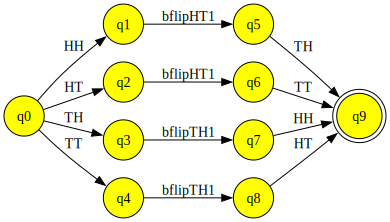

In [45]:
# Check it using defs
# Here coin1 changes
hfst.regex('bflip1Diff', definitions=defs).view()

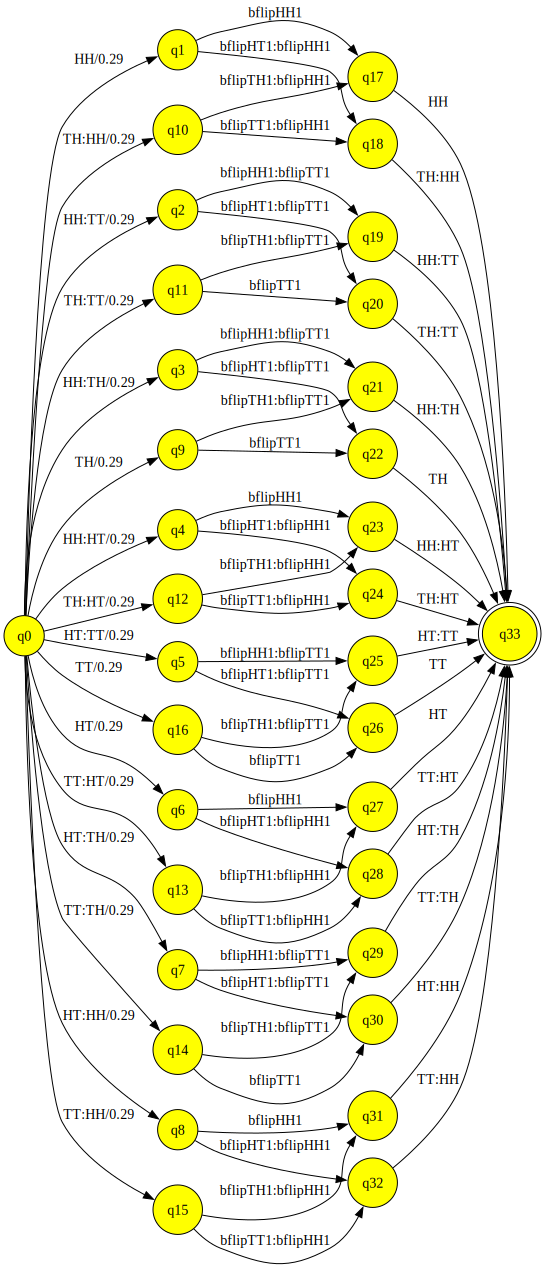

In [46]:
# When there is any kind of biased flip, Amy tends to think
# the coin stays the same.

amyBflip1SameRel = Cnr(hfst.regex('[bflip1Any .o. eCe .o. bflip1Same]', definitions=defs),threequarter)
amyBflip1SameRel.minimize()

amyBflip1SameRel.view()
# This has weights 0.75
# The event on top is unconstrained. The event on the bottom has no change.

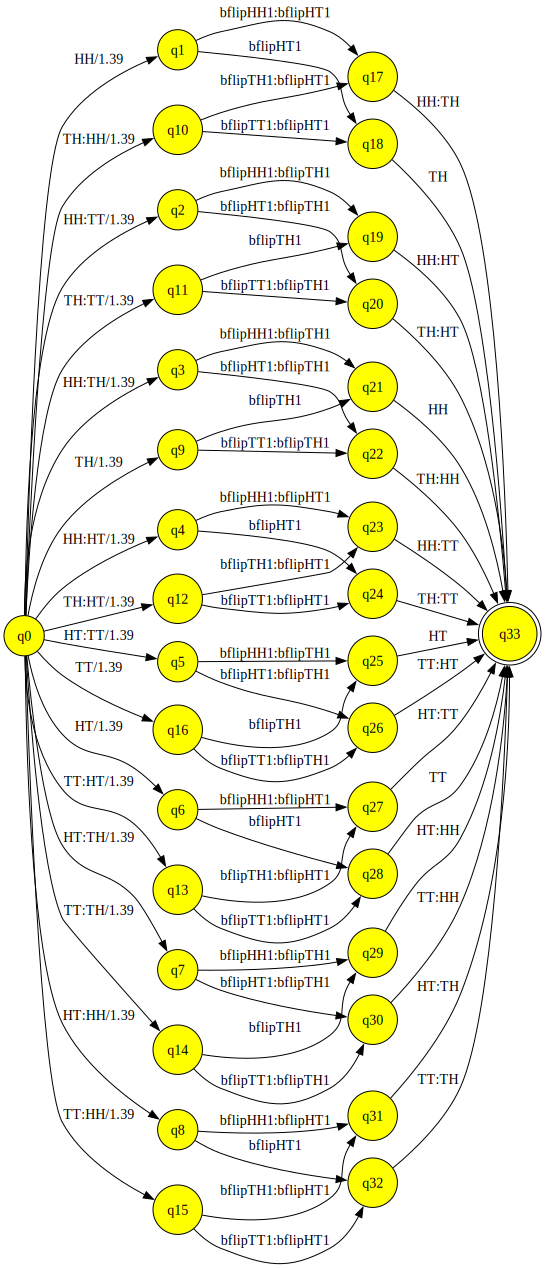

In [47]:
# When there is any kind of biased flip, the agents tend to doubt
# that coin1 changes.

amyBflip1DiffRel = Cnr(hfst.regex('[bflip1Any .o. eCe .o. bflip1Diff]', definitions=defs),onequarter)
amyBflip1DiffRel.minimize()

amyBflip1DiffRel.view()
# This has weights 0.25
# The event on top is unconstrained. The event on the bottom has a change in coin1.

In [48]:
# Form the union of the Same and Diff relations
amyBflip1Rel = amyBflip1SameRel.copy()
amyBflip1Rel.disjunct(amyBflip1DiffRel)

# Bob has the same alternative relation
bobBflip1Rel = amyBflip1Rel.copy()

# Update the definitions
defs.update({"amyBflip1Rel":amyBflip1Rel, "bobBflip1Rel":bobBflip1Rel}) 

In [49]:
amyEventAlt = amyAnnounceRel.copy()
amyEventAlt.disjunct(amyPeekamyRel)
amyEventAlt.disjunct(amyPeekbobRel)
amyEventAlt.disjunct(amyBflip1Rel)
amyEventAlt.minimize()
defs.update({"amyEventAlt":amyEventAlt}) 

In [50]:
# Build up event alternative relation for Bob
bobAnnounceRel = amyAnnounceRel.copy()

In [51]:
bobPeekbobRel = hfst.regex('[peekbobH1 .o. eCe .o. peekbobH1] |' +
                           '[peekbobT1 .o. eCe .o. peekbobT1] |' +
                           '[peekbobH2 .o. eCe .o. peekbobH2] |' +
                           '[peekbobT2 .o. eCe .o. peekbobT2]',definitions=defs)

In [52]:
bobPeekamyRel = hfst.regex('[peekamyH1 .o. eCe .o. peekamyH1] |' +
                           '[peekamyT1 .o. eCe .o. peekamyT1] |' +
                           '[peekamyH2 .o. eCe .o. peekamyH2] |' +
                           '[peekamyT2 .o. eCe .o. peekamyT2] |' +
                           '[peekamyH1 .o. eCe .o. peekamyT1] |' +
                           '[peekamyT1 .o. eCe .o. peekamyH1] |' +
                           '[peekamyH2 .o. eCe .o. peekamyT2] |' +
                           '[peekamyT2 .o. eCe .o. peekamyH2]',definitions=defs)

In [53]:
bobEventAlt = bobAnnounceRel.copy()
bobEventAlt.disjunct(bobPeekbobRel)
bobEventAlt.disjunct(bobPeekamyRel)
bobEventAlt.disjunct(bobBflip1Rel)
bobEventAlt.minimize()

In [54]:
defs.update({"bobEventAlt":bobEventAlt})

<libhfst_dev.HfstTransducer; proxy of <Swig Object of type 'std::vector< hfst::HfstTransducer >::value_type *' at 0x7fed50074120> >

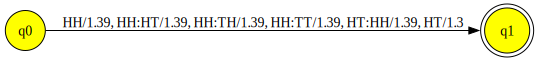

In [133]:
# We probably don't need this
StProb = onequarter.copy()
StProb.concatenate(St)
onequarter.view()

In [134]:
onequarter.extract_paths()
# In any state, this a flat distribution on the related states

{'HH': [('HH', 1.3862940073013306),
  ('HT', 1.3862940073013306),
  ('TH', 1.3862940073013306),
  ('TT', 1.3862940073013306)],
 'HT': [('HH', 1.3862940073013306),
  ('HT', 1.3862940073013306),
  ('TH', 1.3862940073013306),
  ('TT', 1.3862940073013306)],
 'TH': [('HH', 1.3862940073013306),
  ('HT', 1.3862940073013306),
  ('TH', 1.3862940073013306),
  ('TT', 1.3862940073013306)],
 'TT': [('HH', 1.3862940073013306),
  ('HT', 1.3862940073013306),
  ('TH', 1.3862940073013306),
  ('TT', 1.3862940073013306)]}

In [135]:
X = Cn(onequarter,onequarter)
X.extract_paths()

{'HH': [('HH', 2.772588014602661)],
 'HT': [('HT', 2.772588014602661)],
 'TH': [('TH', 2.772588014602661)],
 'TT': [('TT', 2.772588014602661)]}

In [136]:
# World alternative relation for Amy via Kleene star in the KAT algebra
# I tried to weight the alternatives to a state world by 1/4, but could not do it.
amy = RelKst(amyEventAlt)
amy.determinize()

# World alternative relation for Bob  
bob = RelKst(bobEventAlt)
bob.determinize()

defs.update({"amy":amy,"bob":bob})

In [137]:
# Alternatives for Amy to Bob peeking at T2 in HT
X = Cn(HT,peekbobT2)
print(list(X.extract_paths().keys()))
X.compose(amy)
X.output_project()
print(list(X.extract_paths().keys()))
X.extract_paths()

['HTpeekbobT2HT']
['HHpeekbobH2HH', 'HTpeekbobT2HT', 'THpeekbobH2TH', 'TTpeekbobT2TT']


{'HHpeekbobH2HH': [('HHpeekbobH2HH', 0.0)],
 'HTpeekbobT2HT': [('HTpeekbobT2HT', 0.0)],
 'THpeekbobH2TH': [('THpeekbobH2TH', 0.0)],
 'TTpeekbobT2TT': [('TTpeekbobT2TT', 0.0)]}

In [138]:
# Alternatives for Amy to Amy peeking at T2 in HT
X = Cn(HT,peekamyT2)
print(list(X.extract_paths().keys()))
X.compose(amy)
X.output_project()
print(list(X.extract_paths().keys()))

['HTpeekamyT2HT']
['HTpeekamyT2HT', 'TTpeekamyT2TT']


In [142]:
# Conjunction
def And(X,Y):
    Z = X.copy()
    Z.intersect(Y)
    Z.minimize()
    return(Z)

In [125]:
# Short worlds
One = Event;
Two = Cn(One,Event)
Three = Cn(Two,Event)

# Alternatives for an agent in a world

In [141]:
# Box modality
# It's the dual of diamond.
# define Box(R,X) Not(Dia(R,Not(X)));
def Box(R,X):
    Z = Not(Dia(R,Not(X)))
    Z.minimize()
    return(Z)

In [156]:
def Alt(agent,w): 
    u = w.copy() 
    u.compose(agent) 
    u.output_project() 
    u.minimize() 
    return(u)

In [197]:
# Relation that deletes all but the final state of a world. Note that .#. is in 
# the left context, not the deletion term. In practice this seems to do the right
# thing in summing probabilities.
EndState0 = hfst.regex('[St BareEvent]+ -> 0 || .#. _ St .#.', definitions=defs)

In [175]:
# X is a set of worlds, in the application the alternative set for an agent in
# a specific world. This works by deleting the initial parts of the worlds,
# which has the effect of summing the probabilities. 
# This is valid only when the input is a constant world.
def state_distribution(X):
    Z = X.copy()
    Z.compose(EndState0)
    Z.output_project()
    Z.intersect(St)
    Z.minimize()
    # WARNING taking the values will only work if the input is unique
    return(sum(list(Z.extract_paths().values()),[]))

## Example 1
Amy initially identifies the state as HT, then loses information due to biased flips.  Bob
never learns anything, and so retains a flat distribution.

In [185]:
w1 = Cn(HT,peekamyH1)
print('world w1')
show(w1)
print("\nAmy's alternatives and their state probabilities")
X = Alt(amy,w1)
show(X)
print(state_distribution(X))
print("\nBobs's alternatives and their state probabilities")
X = Alt(bob,w1)
show(X)
print(state_distribution(X))
print('\nNote that all the probabilities are 1.0, they have to be normalized.')

world w1
['HTpeekamyH1HT']

Amy's alternatives and their state probabilities
['HHpeekamyH1HH', 'HTpeekamyH1HT']
[('HH', 0.0), ('HT', 0.0)]

Bobs's alternatives and their state probabilities
['HHpeekamyH1HH', 'HTpeekamyH1HT', 'THpeekamyT1TH', 'TTpeekamyT1TT']
[('HH', 0.0), ('HT', 0.0), ('TH', 0.0), ('TT', 0.0)]

Note that all the probabilities are 1.0, they have to be normalized.


In [189]:
w2 = Cn(w1,peekamyT2)
print('world w2')
show(w2)
print("\nAmy's alternatives and their state probabilities")
X = Alt(amy,w2)
show(X)
print(state_distribution(X))
print("\nBobs's alternatives and their state probabilities")
X = Alt(bob,w2)
show(X)
print(state_distribution(X))
print('\nIn w2, Amy knows the state.')

world w2
['HTpeekamyH1HTpeekamyT2HT']

Amy's alternatives and their state probabilities
['HHpeekamyH1HH', 'HTpeekamyH1HT']
[('HH', 0.0), ('HT', 0.0)]

Bobs's alternatives and their state probabilities
['HHpeekamyH1HH', 'HTpeekamyH1HT', 'THpeekamyT1TH', 'TTpeekamyT1TT']
[('HH', 0.0), ('HT', 0.0), ('TH', 0.0), ('TT', 0.0)]

In w2, Amy knows the state.


In [193]:
# Add a biased flip of coin1 that does not chage the state
w3 = Cn(w2, bflipHH1)
print('world w3')
show(w3)
print("\nAmy's alternatives and their state probabilities")
X = Alt(amy,w3)
show(X)
print(state_distribution(X))
print("\nBobs's alternatives and their state probabilities")
X = Alt(bob,w3)
show(X)
print(state_distribution(X))
print('\nIn w3, Amy has become uncertain about coin1, but still considers H more probable. \nBob never learns anything.')

world w3
['HTpeekamyH1HTpeekamyT2HTbflipHH1HT']

Amy's alternatives and their state probabilities
['HTpeekamyH1HTpeekamyT2HTbflipHH1HT', 'HTpeekamyH1HTpeekamyT2HTbflipHT1TT']
[('HT', 0.2880859971046448), ('TT', 1.386718988418579)]

Bobs's alternatives and their state probabilities
['HHpeekamyH1HHpeekamyH2HHbflipHH1HH', 'HTpeekamyH1HTpeekamyT2HTbflipHH1HT', 'THpeekamyT1THpeekamyH2THbflipTT1TH', 'TTpeekamyT1TTpeekamyT2TTbflipTT1TT', 'HHpeekamyH1HHpeekamyH2HHbflipHT1TH', 'HTpeekamyH1HTpeekamyT2HTbflipHT1TT', 'THpeekamyT1THpeekamyH2THbflipTH1HH', 'TTpeekamyT1TTpeekamyT2TTbflipTH1HT']
[('HH', 0.2880859971046448), ('HT', 0.2880859971046448), ('TH', 0.2880859971046448), ('TT', 0.2880859971046448)]

In w3, Amy has become uncertain about coin1, but still considers H more probable. 
Bob never learns anything.


In [196]:
# Add an additional biased flip of coin1.
w4 = Cn(w4, bflipHH1)
print('world w4')
show(w4)
print("\nAmy's alternatives and their state probabilities")
X = Alt(amy,w4)
show(X)
print(state_distribution(X))
print("\nBobs's alternatives and their state probabilities")
X = Alt(bob,w4)
show(X)
print(state_distribution(X))
print('\nAmy is less confident about H1 than in w3.')
print("Bob's world alternatives are numerous, but his state distribution is flat.")

world w4
['HTpeekamyH1HTpeekamyT2HTbflipHH1HTbflipHH1HTbflipHH1HTbflipHH1HT']

Amy's alternatives and their state probabilities
['HTpeekamyH1HTpeekamyT2HTbflipHH1HTbflipHH1HTbflipHH1HTbflipHH1HT', 'HTpeekamyH1HTpeekamyT2HTbflipHH1HTbflipHH1HTbflipHH1HTbflipHT1TT', 'HTpeekamyH1HTpeekamyT2HTbflipHH1HTbflipHH1HTbflipHT1TTbflipTT1TT', 'HTpeekamyH1HTpeekamyT2HTbflipHH1HTbflipHT1TTbflipTT1TTbflipTT1TT', 'HTpeekamyH1HTpeekamyT2HTbflipHT1TTbflipTT1TTbflipTT1TTbflipTT1TT', 'HTpeekamyH1HTpeekamyT2HTbflipHH1HTbflipHH1HTbflipHT1TTbflipTH1HT', 'HTpeekamyH1HTpeekamyT2HTbflipHH1HTbflipHT1TTbflipTH1HTbflipHH1HT', 'HTpeekamyH1HTpeekamyT2HTbflipHH1HTbflipHT1TTbflipTT1TTbflipTH1HT', 'HTpeekamyH1HTpeekamyT2HTbflipHT1TTbflipTH1HTbflipHH1HTbflipHH1HT', 'HTpeekamyH1HTpeekamyT2HTbflipHT1TTbflipTT1TTbflipTH1HTbflipHH1HT', 'HTpeekamyH1HTpeekamyT2HTbflipHT1TTbflipTT1TTbflipTT1TTbflipTH1HT', 'HTpeekamyH1HTpeekamyT2HTbflipHH1HTbflipHT1TTbflipTH1HTbflipHT1TT', 'HTpeekamyH1HTpeekamyT2HTbflipHT1TTbflipTH1HTbflipHH1HT

## Example 2
Information after public announcement of HT.

In [199]:
w1 = Cn(Cn(HT,announceH1),announceT2)
print('world w1')
show(w1)
print("\nAmy's alternatives and their state probabilities")
X = Alt(amy,w1)
show(X)
print(state_distribution(X))
print("\nBobs's alternatives and their state probabilities")
X = Alt(bob,w1)
show(X)
print(state_distribution(X))
print('\nThe agents have identified the world and the state.')

world
['HTannounceH1HTannounceT2HT']

Amy's alternatives and their state probabilities
['HTannounceH1HTannounceT2HT']
[('HT', 0.0)]

Bobs's alternatives and their state probabilities
['HTannounceH1HTannounceT2HT']
[('HT', 0.0)]

The agents have identified the world and the state.


After a biased flip, this time a changing one, the agents have lost confidence, but still tend to believe H1.

In [200]:
w2 = Cn(w1, bflipHT1)
print('world w2')
show(w2)
print("\nAmy's alternatives and their state probabilities")
X = Alt(amy,w2)
show(X)
print(state_distribution(X))
print("\nBobs's alternatives and their state probabilities")
X = Alt(bob,w2)
show(X)
print(state_distribution(X))
print('\nIn w2, the agents become uncertain about coin1, but still consider H more probable. \nTheir information is in fact bad.')

world w2
['HTannounceH1HTannounceT2HTbflipHT1TT']

Amy's alternatives and their state probabilities
['HTannounceH1HTannounceT2HTbflipHH1HT', 'HTannounceH1HTannounceT2HTbflipHT1TT']
[('HT', 0.2880859971046448), ('TT', 1.386718988418579)]

Bobs's alternatives and their state probabilities
['HTannounceH1HTannounceT2HTbflipHH1HT', 'HTannounceH1HTannounceT2HTbflipHT1TT']
[('HT', 0.2880859971046448), ('TT', 1.386718988418579)]

In w2, the agents become uncertain about coin1, but still consider H more probable. 
Their information is in fact bad.


## Modal logic

In [139]:
# Diamond modality
# R is a Kripke relation on W
# X is a proposition
# define Dia(R,X) [R .o. X].u;
def Dia(R,X):
    Z = R.copy()
    Z.compose(X)
    Z.input_project()
    Z.minimize()
    return(Z)

In [140]:
# Complement
# X assumed to be a set
# define Not(X) W - X;
def Not(X):
    Z = W.copy()
    Z.minus(X)
    Z.minimize()
    return(Z)

In [115]:
def BoxSt(R,V,S):
    X = Cn(W,S)
    Z = And(V,Box(R,X))
    show(Z)

In [116]:
# Two-event worlds where amy has identified the state H1T2
BoxSt(amy,Two,H1T2)

['1001announceH11001announceT21001', '1001announceH11001peekamyT21001', '1001announceT21001announceH11001', '1001announceT21001peekamyH11001', '1001peekamyH11001announceT21001', '1001peekamyH11001peekamyT21001', '1001peekamyT21001announceH11001', '1001peekamyT21001peekamyH11001']


['1001bflipHH11001', '1010bflipHH11010']


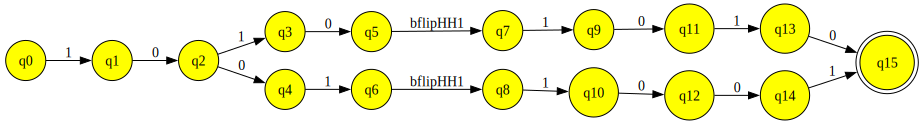

In [117]:
show(bflipHH1)
bflipHH1.view()

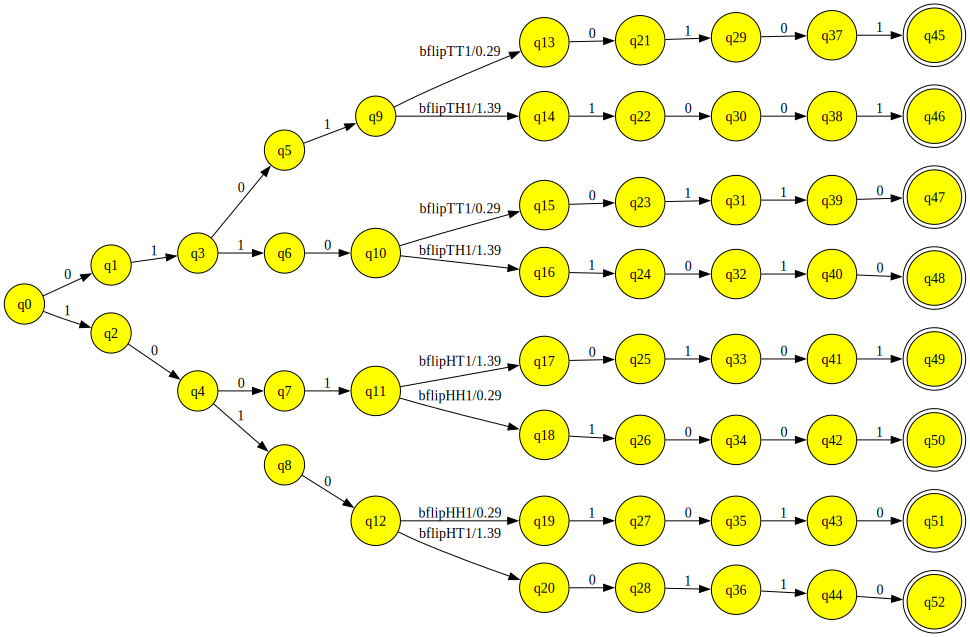

In [118]:
X = Cn(T2,bflipHH1)
X.view()
X.compose(amy)
X.output_project()
X.view()
# 1.3862943611198906 1/4
# 0.2876820724517809 3/4

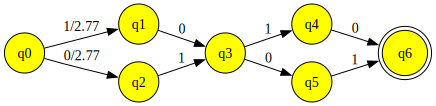

In [119]:
onequarter.view()
X = onequarter.copy()
X.view()
Y = Cn(X,X)
Y.view()

In [120]:
## OK these are -log weights
Y.extract_paths()

{'0101': [('0101', 2.772588014602661)],
 '0110': [('0110', 2.772588014602661)],
 '1001': [('1001', 2.772588014602661)],
 '1010': [('1010', 2.772588014602661)]}

In [121]:
X = Cn(H1T2,Cn(peekamyH1,bflipHT1))
X.compose(amy)
X.compose(Cn(Two,T2))
X.output_project()
X.extract_paths()
# The below is a 3/4 probability of H1, and 1/4 probability of T1

{'1001peekamyH11001bflipHH11001': [('1001peekamyH11001bflipHH11001',
   0.2876819968223572)],
 '1001peekamyH11001bflipHT10101': [('1001peekamyH11001bflipHT10101',
   1.3862940073013306)]}

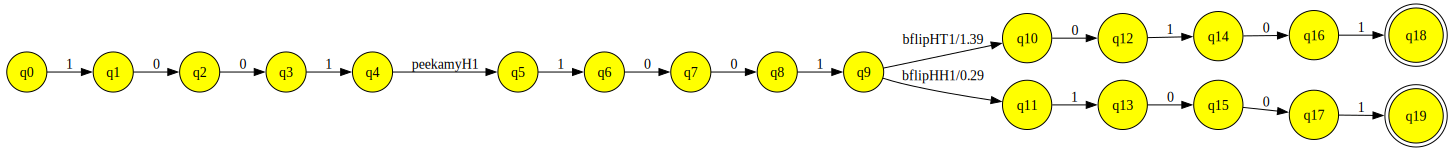

In [122]:
X.determinize() # Don't use minimize, that disambiguates
X.view()

In [123]:
# Why doesn't this work?
X = Cn(H1T2,Cn(peekamyH1,bflipHT1))
X.compose(bob)
X.compose(Cn(Two,T2))
X.output_project()
X.extract_paths()

{}

In [124]:
bob

<libhfst_dev.HfstTransducer; proxy of <Swig Object of type 'std::vector< hfst::HfstTransducer >::value_type *' at 0x7fc350048600> >

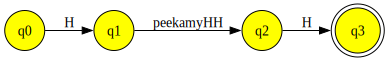

In [66]:
peekamyHH.view()

In [67]:
onequarter.view()

NameError: name 'onequarter' is not defined

In [78]:
threequarter = hfst.regex('St::0.2876820724517809', definitions=defs)
onequarter = hfst.regex('St::1.3862943611198906', definitions=defs)

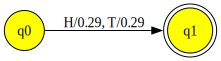

In [70]:
threequarter.view()

In [80]:
w_peekamyHH = Cn(peekamyHH,threequarter)
w_peekamyTT = Cn(peekamyTT,threequarter)
w_peekamyTH = Cn(peekamyTH,onequarter)
w_peekamyHT = Cn(peekamyHT,onequarter)

In [ ]:
w_peekbobHH = Cn(peekbobHH,threequarter)

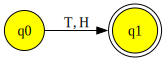

In [75]:
St.view()

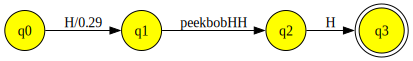

In [76]:
w_peekbobHH = Cn(peekbobHH,threequarter)
w_peekbobHH.view()

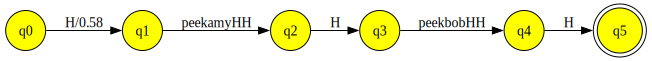

In [77]:
Cn(w_peekamyHH,w_peekbobHH).view()